# Categorical Feature Encoding Challenge EDA & Baseline

<br>

# Categorical Feature Encoding Challenge EDA

## 1. 데이터 둘러보기

먼저 훈련, 테스트, 제출 샘플 데이터를 불러오겠습니다.

In [1]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

데이터를 읽어올 때 `index_col` 파라미터에 'id'를 전달했습니다. `index_col` 은 불러올 DataFrame의 인덱스를 지정하는 파라미터입니다. 열 이름을 전달하면 해당 열을 인덱스로 지정하며, 6장에서처럼 명시하지 않으면 0부터 시작하는 새로운 인덱스 열을 생성해줍니다. 이번대회에서는 `index_col` 을 명시하지 않고 데이터를 불러오면 id라는 열이 보입니다. 이 열은 타깃값을 예측하는 데 어떠한 정보도 제공하지 않고 단지 각 행을 구분하는 역할만 합니다. 그래서 id를 인덱스로 지정한 것입니다.

훈련 데이터와 테스트 데이터 크기를 확인해보겠습니다.

In [2]:
train.shape, test.shape

((300000, 24), (200000, 23))

훈련 데이터는 300,000행 24열, 테스트 데이터는 200,000 행 23열로 구성돼 있습니다. 인공 데이터라 행 개수가 30만 개, 20만 개로 딱 떨어지네요.

이제 훈련 데이터가 어떻게 이루어져 있는지 살펴보겠습니다. 피처 개수가 많아 `train.head()` 로 출력하면 중간에 피처가 생략된 상태로 출력됩니다. 생략된 피처를 표시하는 방법도 있지만 한눈에 보기에 불편합니다. 좌우로 스크롤해야 하기 때문이죠. 대신 `T` 메서드를 호출하여 행과 열 위치를 바꿔주면 한눈에 보기 편합니다.

In [3]:
train.head().T

id,0,1,2,3,4
bin_0,0,0,0,0,0
bin_1,0,1,0,1,0
bin_2,0,0,0,0,0
bin_3,T,T,F,F,F
bin_4,Y,Y,Y,Y,N
nom_0,Green,Green,Blue,Red,Red
nom_1,Triangle,Trapezoid,Trapezoid,Trapezoid,Trapezoid
nom_2,Snake,Hamster,Lion,Snake,Lion
nom_3,Finland,Russia,Russia,Canada,Canada
nom_4,Bassoon,Piano,Theremin,Oboe,Oboe


행과 열이 바뀌었고, 모든 피처의 처음 다섯 개 값까지가 한눈에 들어옵니다. 각 피처에 대해서는 잠시 후 피처 요약표를 만들어 자세히 살펴보겠습니다.

제출 샘플 데이터도 출력해보죠.

In [4]:
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


인덱스는 300,000부터 시작합니다. 테스트 데이터 인덱스가 300,000부터 시작하기 때문입니다. `test.head()` 로 테스트 데이터 인덱스를 확인해보기 바랍니다.

target 열은 0.5로 일괄 입력돼 있습니다. 타깃값은 0과 1, 두 가지인데, 이중 타깃값이 1일 확률을 예측해 저장해주면 됩니다. 즉, 본 경진대회의 목표는 각 테스트 데이터의 타깃값이 1일 확률을 예측하는 것입니다.

### 피처 요약표 만들기

이제 모든 피처를 면밀히 살펴봅시다. 피처 타입이 무엇인지, 결측값은 없는지, 고유한 값은 몇 개인지, 실제 어떤 값이 입력돼 있는지 알아보죠. 이를 위해 피처 요약표를 만들겠습니다.

 피처 요약표는 피처별 데이터 타입, 결측값 개수, 고윳값 개수, 실제 입력값 등 피처에 관한 정보가 정리된 표입니다.
 
 피처 요약표를 만드는 과정을 다음의 세 단계로 나눠 살펴보겠습니다.
 1. 피처별 데이터 타입 DataFrame 생성
 2. 인덱스 재설정 후 열 이름 변경
 3. 결측값 개수, 고윳값 개수, 1~3행 입력값 추가

#### 피처별 데이터 타입 DataFrame 생성

피처별 데이터 타입부터 구해보겠습니다. DataFrame 객체에서 `dtypes`를 호출하면 피처별 데이터 타입을 반환해줍니다. 피처가 많아 여기서는 첫 5개만 출력해보겠습니다.

In [5]:
train.dtypes[:5]

bin_0     int64
bin_1     int64
bin_2     int64
bin_3    object
bin_4    object
dtype: object

이 값을 입력으로 DataFrame을 새로 생성하면 피처별 데이터 타입이 입력된 DataFrame이 만들어집니다. 이때 다음과 같이 columns 파라미터로 원하는 열 이름을 설정할 수 있습니다.

In [6]:
summary = pd.DataFrame(train.dtypes, columns=['데이터 타입'])
summary.head()

,데이터 타입
bin_0,int64
bin_1,int64
bin_2,int64
bin_3,object
bin_4,object


#### 인덱스 재설정 후 열 이름 변경

그런데 피처 이름들이 인덱스로 사용되었습니다. `reset_index()`로 인덱스를 재설정하겠습니다. `reset_index()`를 호출하면 현재 인덱스를 열로 옮기고 새로운 인덱스를 만듭니다. 새로운 인덱스는 0부터 시작해 1씩 증가하는 정수이며, 옮겨진 열의 이름은 'index'가 됩니다.

In [7]:
summary = summary.reset_index()
summary.head()

,index,데이터 타입
0,bin_0,int64
1,bin_1,int64
2,bin_2,int64
3,bin_3,object
4,bin_4,object


현재 피처 이름이 포함된 열 이름이 index 입니다. `rename()` 함수를 활용해 열 이름을 '피처'로 바꿔주겠습니다.

In [8]:
summary = summary.rename(columns={'index': '피처'})
summary.head()

,피처,데이터 타입
0,bin_0,int64
1,bin_1,int64
2,bin_2,int64
3,bin_3,object
4,bin_4,object


열 이름이 index에서 피처로 잘 바뀌었네요.

#### 결측값 개수, 고윳값 개수, 1~3행 입력값 추가

DataFrame에 결측값 개수, 고윳값 개수, 첫 세 개 행에 입력된 값을 추가해보겠습니다.

In [9]:
# 피처별 결측값 개수
summary['결측값 개수'] = train.isnull().sum().values

# 피처별 고윳값 개수
summary['고윳값 개수'] = train.nunique().values

# 1~3행에 입력되어 있는 값
summary['첫 번째 값'] = train.loc[0].values
summary['두 번째 값'] = train.loc[1].values
summary['세 번째 값'] = train.loc[2].values

summary.head()

,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y


`train.isnull().sum().values` 은 피처별 결측값 개수를 DataFrame에 추가합니다. `isnull()`은 결측값 포함 여부를 True, False로 반환하는 함수입니다. 파이썬에서 True는 1, False는 0으로 간주합니다. 따라서 `isnull()`을 적용한 DataFrame에 `sum()` 함수를 호출하면 True의 개수, 즉 피처별 결측값 개수를 구해줍니다.

`train.nunique().values` 은 피처별 고윳값 개수를 추가합니다. `nunique()`는 피처별 고윳값 개수를 구하는 함수입니다.

`train.loc[].values` 은 훈련 데이터 1~3행에 입력된 값을 요약표 DataFrame에 추가하는 코드입니다. 각 피처에 실제 어떤 값이 들어있는지 확인하려고 추가했습니다. loc[0]은 첫 번째 행, loc[1]은 두 번째 행, loc[2]은 세 번째 행의 값을 의미합니다.

그런데 마지막에 values가 붙었습니다. 이해를 돕기 위해 values 코드를 적용하기전 객체가 어떻게 생겼는지 보겠습니다.

In [10]:
train.isnull().sum()

bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

반환 타입인 Series는 인덱스(bin_0, bin_1 등)와 값(value)의 쌍으로 이루어져 있습니다. Series 객체에서 값만 추출하려면 values를 호출하면 됩니다. 위에서 모두 `values` 코드로 Series의 값을 불러와 피처 요약표(summary)에 추가했습니다.

드디어 피처 요약표가 완성됐습니다. summary를 출력하면 다음과 같이 나옵니다.

In [11]:
# 스텝 1 : 피처별 데이터 타입 DataFrame 생성
summary = pd.DataFrame(train.dtypes, columns=['데이터 타입'])

# 스텝 2 : 인덱스 재설정 후 열 이름 변경
# 2-1 : 인덱스 재설정
summary = summary.reset_index()
# 2-2 : 열 이름 변경
summary = summary.rename(columns={'index': '피처'})

# 스텝 3 : 결측값 개수, 고윳값 개수, 1~3행 입력값 추가
# 피처별 결측값 개수
summary['결측값 개수'] = train.isnull().sum().values
# 피처별 고윳값 개수
summary['고윳값 개수'] = train.nunique().values
# 1~3행에 입력되어 있는 값
summary['첫 번째 값'] = train.loc[0].values
summary['두 번째 값'] = train.loc[1].values
summary['세 번째 값'] = train.loc[2].values

summary

,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


지금까지 피처 요약표를 만드는 방법을 배웠습니다. 간단하게 함수 형태로 만들어보겠습니다.

In [12]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    
    return summary

In [13]:
resumetable(train)

데이터 세트 형상: (300000, 24)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


### 피처 요약표 해석하기

앞에서 생성한 피처 요약표를 해석해보죠. 내용이 많으니 비슷한 피처끼리 다음의 네 부류로 묶어 설명하겠습니다.
1. 이진(binary) 피처 : bin_0 ~ bin_4
2. 명목형(nominal) 피처 : nom_0 ~ nom_9
3. 순서형(ordinal) 피처 : ord_0 ~ ord_5
4. 그 외 피처 : day, month, target

순서대로 이진(binary) 피처들부터 보시죠.

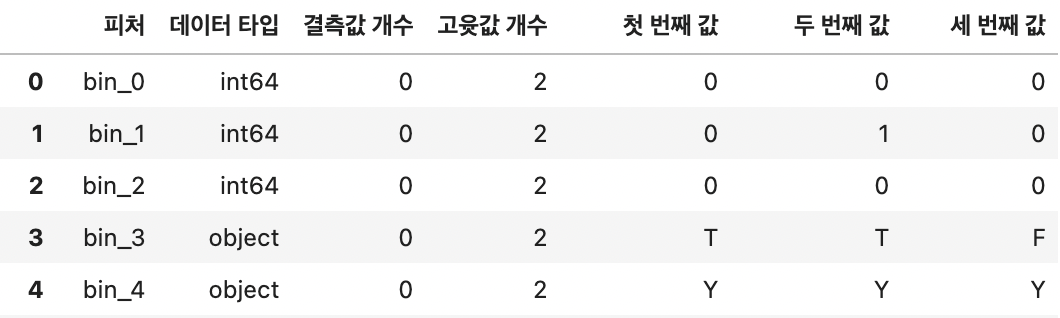

보다시피 이 피처들은 고윳값이 모두 2개입니다. 이진 피처라 그렇습니다. 이중 bin_0, bin_1, bin_2는 데이터 타입이 int64고, 실젯값이 0 또는 1로 구성돼 있습니다. bin_3, bin_4는 object 타입이고, 실젯값은 T 또는 F(bin_3 피처), Y 또는 N(bin_4 피처)입니다. T는 True, F는 False, Y는 Yes, N은 No를 의미한다고 보면 되겠군요. 그러므로 모델링할 때 T와 Y는 1로, F와 N은 0으로 인코딩하겠습니다.

머신러닝 모델은 숫자만 인식하기 때문입니다. 결측값 개수 열에 나와 있듯이 이진 피처에 결측값은 하나도 없네요.

다음으로 명목형 피처들을 살펴보겠습니다. 이 피처들은 명목형 데이터(nominal data) 입니다.

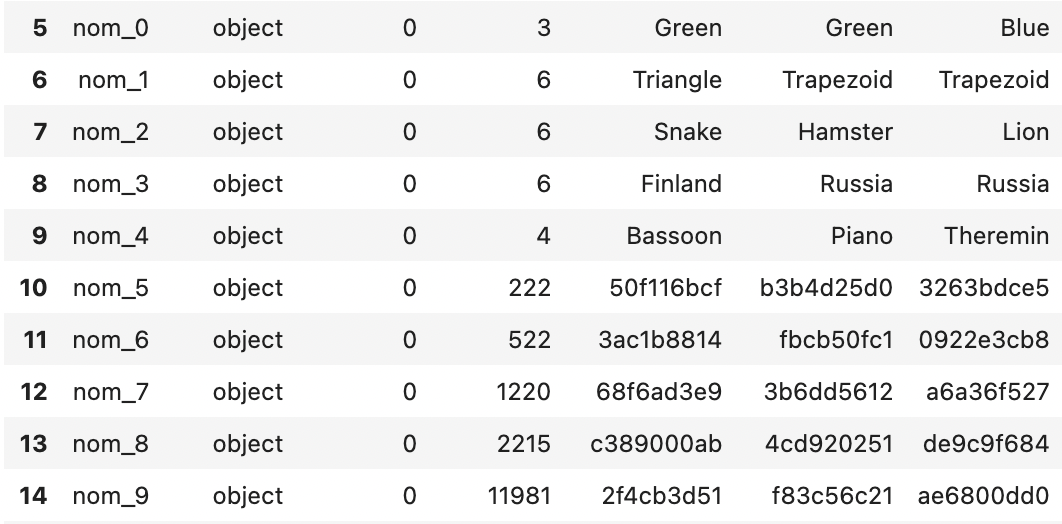

명목형 피처는 모두 object 타입이고 결측값은 없습니다. nom_0부터 nom_4는 고윳값이 6개 이하인데, nom_5부터 nom_9는 고윳값이 많습니다. 또한, nom_5부터 nom_9 피처에는 의미를 알 수 없는 값이 입력돼 있네요.

이어서 순서형(ordinal) 피처들도 살펴보겠습니다.

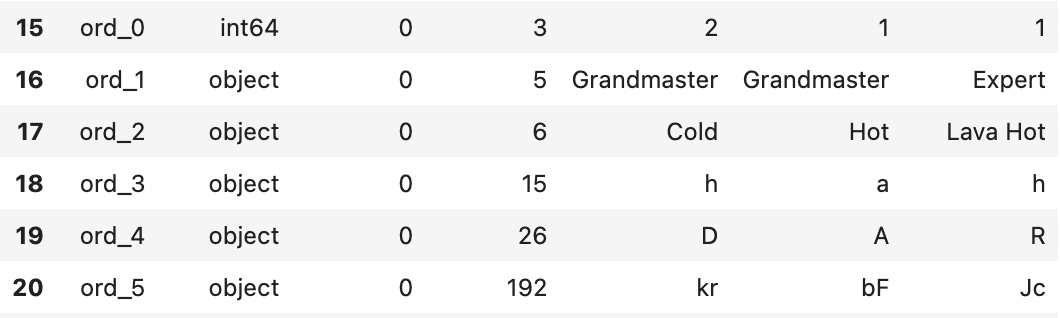

ord_0 피처만 int64 타입이고 나머지는 object 타입입니다. 결측값은 역시나 없네요. 명목형 데이터와 다르게 순서형 데이터는 순서가 중요합니다. 순서에 따라 타깃값에 미치는 영향이 다르기 때문입니다. 그래서 순서에 유의하며 인코딩해야 합니다.

순서를 파악하기 위해 순서형 피처의 고윳값을 출력해보겠습니다. 고윳값 개수가 적은 ord_0, ord_1, ord_2 피처부터 보시죠. 다음과 같이 `unique()` 함수로 고윳값을 구할 수 있습니다.

In [14]:
for i in range(3):
    feature = 'ord_' + str(i)
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_0 고윳값: [2 1 3]
ord_1 고윳값: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고윳값: ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


`unique()` 함수는 고윳값이 등장한 순으로 출력해주니 감안해주세요. ord_0 피처의 고윳값은 모두 숫자입니다. 숫자 크기에 순서를 맞추면 되겠네요. ord_1 피처의 고윳값은 캐글 등급입니다. 등급 단계에 따라 Novice, Contributor, Expert, Master, Grandmaster 순으로 맞추겠습니다. ord_2 피처의 고윳값은 춥고 더운 정도를 나타냅니다. Freezing, Cold, Warm, Hot, Boiling Hot, Lava Hot 순서로 맞추겠습니다. 이렇게 정리해놔야 인코딩할 때 순서에 맞게 매핑합니다.

다음으로 고윳값 개수가 많은 ord_3, ord_4, ord_5 피처를 살펴보겠습니다.

In [15]:
for i in range(3, 6):
    feature = 'ord_' + str(i)
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'dZ' 'yN' 'Nf' 'QM' 'jV' 'sY' 'wu' 'SB'
 'UO' 'Mx' 'JX' 'Ry' 'Uk' 'uJ' 'LE' 'ps' 'kE' 'MO' 'kw' 'yY' 'zU' 'bJ'
 'Kf' 'ck' 'mb' '

ord_3, ord_4, ord_5 피처는 알파벳순으로 정렬되어 있습니다. 추후 이 피처들은 알파벳순으로 인코딩하겠습니다.

마지막으로 일, 월, 타깃값 요약표를 보겠습니다.

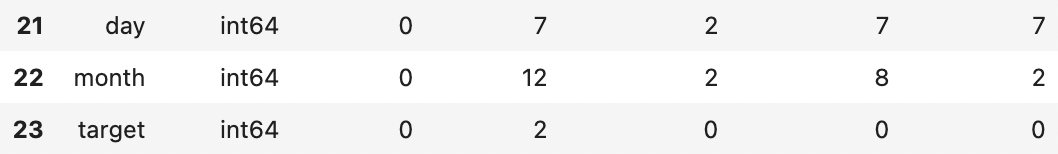

day, month, target 피처 모두 int64 타입이고 결측값은 없습니다. 각각 어떤 고윳값을 가졌는지 보시죠.

In [16]:
print('day 고윳값:', train['day'].unique())
print('month 고윳값:', train['month'].unique())
print('target 고윳값:', train['target'].unique())

day 고윳값: [2 7 5 4 3 1 6]
month 고윳값: [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고윳값: [0 1]


day 피처의 고윳값이 7개입니다. 요일을 나타낸다고 짐작해볼 수 있겠네요. month 피처의 고육값은 1부터 12입니다. 월을 나타냅니다. 마지막으로 타깃값은 0 또는 1로 구성돼 있습니다.

지금까지 피처 요약표를 활용해 각 피처별 타입, 결측값 유무, 고윳값 개수, 실제 입력값을 알아봤습니다.

<br>

## 2. 데이터 시각화

앞 절에서 각 피처의 대략적 구조를 알아봤습니다. 이번 절에서는 이 피처들을 시각화하여 타깃값별 피처 분포를 알아보겠습니다. 그래야 어떤 피처가 중요하고 어떤 고윳값이 타깃값에 영향을 많이 주는지 알게 됩니다.

타깃값, 이진 피처, 명목형 피처, 순서형 피처 순서로 그래프를 그려보겠습니다. 먼저, 시각화 라이브러리를 불러옵니다.

In [17]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### 타깃값 분포

첫 번째로 타깃값 분포를 알아보겠습니다. 타깃값 분포를 알면 데이터가 얼마나 불균형한지 파악하기 쉽습니다. 그래야 부족한 타깃값에 더 집중해 모델링을 수행할 수 있습니다. 이를 위해 분포도 중 하나인 카운트플롯(countplot) 으로 타깃값 0과 1의 개수를 파악하겠습니다. 카운트플롯은 범주형 데이터의 개수를 확인할 때 주로 사용합니다.

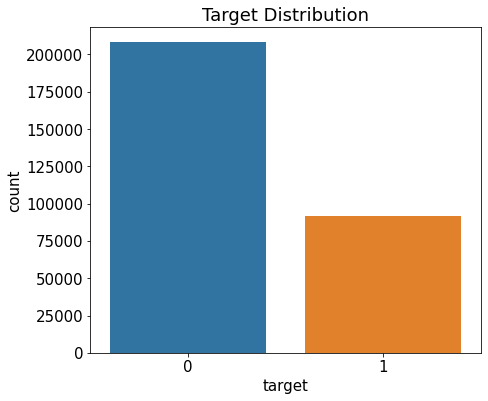

In [18]:
mpl.rc('font', size=15)    # 폰트 크기 설정
plt.figure(figsize=(7, 6)) # Figure 크기 설정

# 타깃값 분포 카운트플롯
ax = sns.countplot(x='target', data=train)
ax.set_title('Target Distribution');

`countplot()`의 x 파라미터에 타깃값('target')을 전달했고, data 파라미터에 훈련 데이터(train)를 전달했습니다. 그러면 train['target']에서 고윳값별로 데이터가 몇 개인지 카운트플롯으로 그려줍니다.

타깃값 0은 20만 개가 좀 넘고 타깃값 1은 9만 개 정도 있습니다.

그런데 이렇게만 그리니 그래프가 좀 심심하네요. 각 값의 비율을 그래프 상단에 표시해주면더 유용할 것 같습니다. 비율을 표시하려면 글자를 쓸 위치를 구해야 하겠죠? 그러려면 먼저 `ax.patches`에 대해 알아야 합니다.

`ax.patches`는 'ax축을 구성하는 그래프 도형 객체 모두를 담은 리스트' 입니다('patch'에는 '조각'이라는 뜻이 있습니다). 앞의 카운트플롯을 그린 ax축의 patches를 출력해보겠습니다.

In [19]:
print(ax.patches)

<Axes.ArtistList of 2 patches>


Rectangle 객체 두 개를 포함하는 리스트네요. 막대 도형 두 개가 그려졌기 때문에 사각형 객체 두 개가 저장돼 있는 겁니다. 이 객체를 활용해 사각형 도형에 대한 정보를 얻을 수 있습니다.

우리는 타깃값 비율을 표시할 위치를 찾아야 합니다. 그 위치를 구하기 위해 사각형의 높이, 너비, 왼쪽 테두리의 x축 위치를 구해보겠습니다.

In [20]:
rectangle = ax.patches[0] # 첫 번째 Rectangle 객체
print('사각형 높이:', rectangle.get_height())
print('사각형 너비:', rectangle.get_width())
print('사각형 왼쪽 테두리의 x축 위치:', rectangle.get_x())

사각형 높이: 208236
사각형 너비: 0.8
사각형 왼쪽 테두리의 x축 위치: -0.4


`get_height()`는 Rectangle 객체 도형의 높이, `get_width()`는 너비, `get_x()`는 왼쪽 테두리 x축 위치를 반환합니다. 이 코드를 이용해 비율을 표시할 위치를 계산해보죠. 막대 바로 위에 가운데 정렬하여 표시하려고 합니다.

In [21]:
print('텍스트 위치의 x좌표:', rectangle.get_x() + rectangle.get_width()/2.0)
print('텍스트 위치의 y좌표:', rectangle.get_height() + len(train)*0.001)

텍스트 위치의 x좌표: 0.0
텍스트 위치의 y좌표: 208536.0


텍스트 표시 위치를 구하는 방법을 알았습니다. 이제 비율을 표시해주는 코드를 함수로 구현한후, 그 함수를 사용해 카운트플롯을 다시 그리겠습니다.

In [22]:
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(x=left_coord + width/2.0,    # x축 위치
                y=height + total_size*0.001, # y축 위치
                s=f'{percent:1.1f}%',        # 입력 텍스트
                ha='center')                 # 가운데 정렬

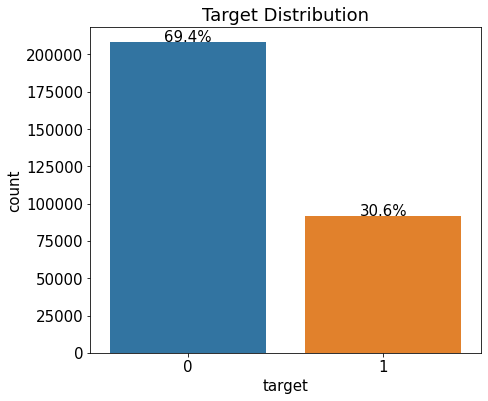

In [23]:
plt.figure(figsize=(7, 6))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train)) # 비율 표시
ax.set_title('Target Distribution');

각 막대 위에 비율이 표시됐습니다. 보기 좋네요. 의미 파악도 쉽고요.

그래프를 보면 타깃값 0과 1이 약 7대 3 비율입니다.

### 이진 피처 분포

이번에는 이진 피처의 분포를 타깃값별로 따로 그려볼 겁니다. 고윳값이 Y와 N인 bin_4 피처를 예로 생각해보죠. 먼저 값이 Y인 데이터 중에서 다시 타깃값이 0인 데이터와 타깃값이 1인 데이터의 분포(비율)를 나눠 그리고, 값이 N인 데이터 중에서도 마찬가지로 타깃값이 0인 비율과 1인 비율을 따로 그린다는 뜻입니다.

이처럼 범주형 피처의 타깃값 분포를 고윳값별로 구분해 그려보는 건 분류 문제에서 종종 쓰는 방법입니다. 특정 고윳값이 특정 타깃값에 치우치는지 확인할 수 있기 때문입니다.

여러 그래프를 격자 형태로 배치하는 GridSpec을 사용해서 그려보겠습니다.

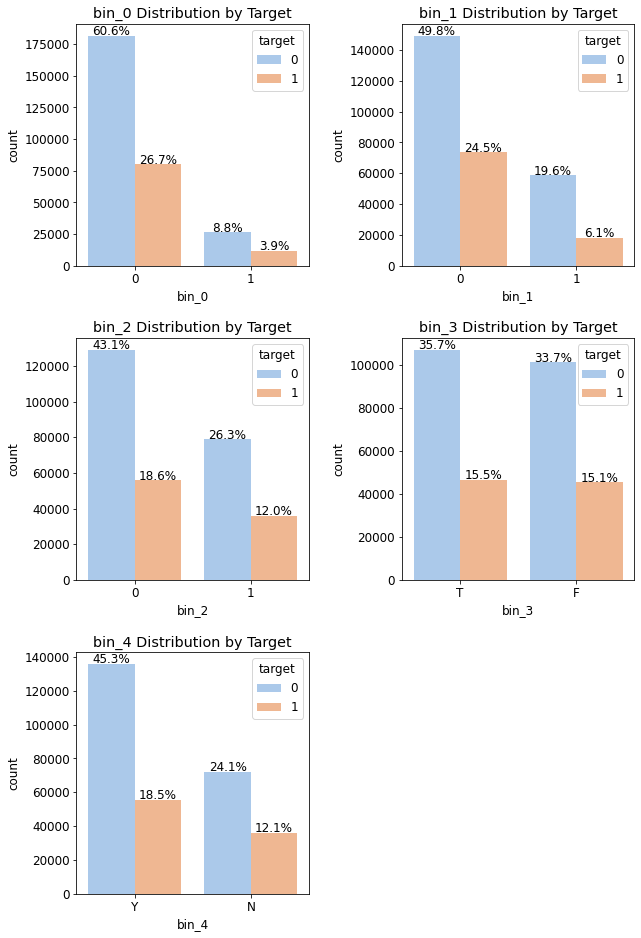

In [24]:
import matplotlib.gridspec as gridspec # 여러 그래프를 격자 형태로 배치

# 3행 2열 틀(Figure) 준비
mpl.rc('font', size=12)
grid = gridspec.GridSpec(3, 2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

# 서브플롯 그리기
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4'] # 피처 목록

for idx, feature in enumerate(bin_features): 
    ax = plt.subplot(grid[idx]) 
    
    # ax축에 타깃값 분포 카운트플롯 그리기
    sns.countplot(x=feature,
                  data=train,
                  hue='target',
                  palette='pastel', # 그래프 색상 설정
                  ax=ax)
    
    ax.set_title(f'{feature} Distribution by Target') # 그래프 제목 설정
    write_percent(ax, len(train))                     # 비율 표시

1. `grid = gridspec.GridSpec(3, 2)`
    * 서브플롯을 3행 2열로 배치한 GridSpec 객체를 grid 변수에 할당합니다.
    * 나중에grid[0], grid[1] ... 식으로 원하는 서브플롯을 지정할 수 있습니다. 이진 피처는 총 5개이므로 마지막 서브플롯에는 그래프를 그리지 않을 계획입니다.
2. `plt.subplots_adjust(wspace=0.4, hspace=0.3)`
    * 서브플롯 사이의 여백을 조정했습니다.
    * `subplots_adjust()`를 활용하면 좌우, 상하 간격을 따로 조정할 수 있습니다.
        * wspace=0.4는 좌우 여백을 축 너비의 40%로, hspace=0.3은 상하 여백을 축 높이의 30%로 설정합니다.

기본 틀을 갖췄으니 이제 서브플롯을 그릴 차례입니다.

먼저 이진 피처의 목록을 bin_features에 담은 후 for문을 활용해 각각의 카운트플롯을 그립니다. 카운트플롯을 그리는 절차는 이렇습니다. bin_features를 순회하며 격자(grid)에서 이번 서브플롯을 그릴 위치를 ax축으로 지정하고 ax축에 타깃값 분포 카운트플롯을 그린 다음 제목을 달고 마지막으로 비율을 표시합니다.

이상으로 타깃값별 이진 피처 분포도를 그리는 방법을 알아봤습니다.

고윳값별로 나눠봐도 타깃값 0, 1의 분포가 대체로 7:3 수준입니다. 즉, 이진 피처들은 특정 타깃값에 치우치지 않았음을 확인할 수 있습니다.

### 명목형 피처 분포

이번에는 명목형 피처 분포와 명목형 피처별 타깃값 1의 비율을 살펴보겠습니다. nom_5부터 nom_9 피처까지는 고윳값 개수가 많고 의미를 알 수 없는 문자열이 입력돼 있으니, 여기서는 nom_0부터 nom_4 피처까지만 시각화하겠습니다.

이제 그래프를 그리는 코드를 살펴보겠습니다. 절차는 다음과 같습니다.
1. 교차분석표 생성 함수 만들기
2. 포인트플롯 생성 함수 만들기
3. 피처 분포도 및 포인트플롯 생성 함수 만들기

순서대로 진행해보죠.

#### 스텝 1 : 교차분석표 생성 함수 만들기

교차표(cross-tabulation) 혹은 교차분석표는 범주형 데이터 2개를 비교 분석하는 데 사용되는 표로, 각 범주형 데이터의 빈도나 통계량을 행과 열로 결합해놓은 표를 말합니다. 여기서 교차분석표를 만드는 이유는 명목형 피처별 타깃값 1 비율을 구하기 위해서입니다. 여기서는 교차분석표를 활용해 2개의 범주형 데이터, 즉 명목형 피처와 타깃값을 비교 분석하고, 그 결과를 이용해 그래프를 그려보겠습니다.

판다스의 `crosstab()` 함수로 교차분석표를 만들 수 있습니다. 명목형 피처인 nom_0와 타깃값인 target 간 교차분석표를 만들어보겠습니다.

In [25]:
pd.crosstab(train['nom_0'], train['target'])

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


nom_0의 고윳값은 Blue, Green, Red입니다. 이 교차분석표는 고윳값별 타깃값 0과 1이 몇개인지 나타내줍니다. 예를 들어, nom_0가 Blue이면서 타깃값이 0인 데이터가 72,914개고, 타깃값이 1인 데이터는 23,252개라는 의미입니다.

개수를 그대로 나타내기보다는 비율로 표현하는 게 한눈에 이해하기 쉽습니다. normalize 파라미터를 추가해 정규화해보겠습니다. normalize 파라미터에 'index'를 전달하면 인덱스를 기준으로 정규화합니다. 이 교차분석표에서 인덱스는 nom_0이므로 각 행별로, 즉 고윳값별로 비율을 구한다는 뜻입니다. 교차분석표의 Blue 행을 보시죠. 72,914와 23,252를 정규화한 값(비율)을 구해보죠.

* 72,914/(72,914 + 23,252) = 0.75820976
* 23,252/(72,914 + 23,252) = 0.24179024

비율이기 때문에 두 값을 더하면 1이 됩니다. 이를 다시 백분율로 표현하기 위해 정규화된 교차분석표에 100을 곱하겠습니다.

In [26]:
# 정규화 후 비율을 백분율로 표현
crosstab = pd.crosstab(train['nom_0'], train['target'], normalize='index')*100
crosstab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


인덱스 기준으로 정규화한 교차분석표가 백분율로 잘 표현됐습니다.

이어서 인덱스를 재설정하겠습니다. 현재 인덱스가 피처 이름(nom_0)인데, 이를 열로 가져와야하기 때문입니다. 열로 가져오는 이유는 피처가 열로 설정돼 있어야 그래프를 그리기 편하기 때문이고요.

In [27]:
crosstab = crosstab.reset_index() # 인덱스 재설정
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


교차분석표는 앞으로 계속 사용합니다. 재사용하려면 함수로 만들어놓는 게 좋겠죠?

In [28]:
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

다음과 같이 이 함수에 데이터프레임과 피처 이름을 인수로 건네면 앞서와 동일한 결과를 내어줍니다.

In [29]:
crosstab = get_crosstab(train, 'nom_0')
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


한편, 앞의 그림에서 포인트플롯은 명목형 피처별 타깃값 1 비율을 나타내는 그래프라고 했습니다. 교차분석표에서 이 비율들만 가져오려면 어떻게 해야 할까요? 다음과 같이 타깃값 1 비율에 해당하는 열의 이름인 '1'을 인수로 전달하면 됩니다.

In [30]:
crosstab[1]

0    24.179024
1    32.714522
2    35.105173
Name: 1, dtype: float64

이 값은 nom_0 피처의 고윳값별 타깃값 1 비율입니다. 다음 스텝에서 포인트플롯을 그릴 때 사용할 데이터입니다.

#### 스텝 2 : 포인트플롯 생성 함수 만들기

스텝 1에서 구한 교차분석표를 사용하여 타깃값 1의 비율을 나타내는 포인트플롯을 그리는 함수를 만들겠습니다. 함수 이름은 `plot_pointplot()` 이며 다음의 세 파라미터를 받습니다.
* ax: 포인트플롯을 그릴 축
* feature: 포인트플롯으로 그릴 피처
* crosstab : 교차분석표

`plot_pointplot()` 은 이미 카운트플롯이 그려진 축에 포인트플롯을 중복으로 그려줍니다.

In [31]:
def plot_pointplot(ax, feature, crosstab):
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab,
                        order=crosstab[feature].values, # 포인트플롯 순서
                        color='black',                  # 포인트플롯 색상
                        legend=False)                   # 범례 미표시
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1) # y축 범위 설정
    ax2.set_ylabel('Target 1 Ratio(%)')

축 하나에 서로 다른 그래프를 그리려면 x축을 공유해야 합니다. `ax.twinx()`로 x축은 공유하지만 y축은 공유하지 않는 새로운 축 ax2를 만들었습니다. ax는 카운트플롯을 그리기 위한 축이고, ax2는 포인트플롯을 그리기 위한 축입니다. ax와 ax2는 x축을 공유하지만, y축은 서로 다릅니다.

`pointplot()`의 x 파라미터에는 피처, y 파라미터에는 '타깃값이 1인 비율'을 나타내는 1, data 파라미터에는 교차분석표 crosstab을 전달했습니다. order 파라미터에는 포인트플롯을 그릴 순서를 전달할 수 있습니다. order=crosstab[feature].values는 교차분석표의 피처(열)순서대로 그리겠다는 뜻입니다.

`set_ylim()`은 포인트플롯을 더 보기 좋게 하려고 y축의 범위를 설정한 것입니다. crosstab[1](타깃값이 1인 비율) 중 최솟값에서 5를 뺀 수치부터 최댓값에 1.1을 곱한 수치까지로 잡았습니다.

#### 스텝 3 : 피처 분포도 및 피처별 타깃값 1의 비율 포인트플롯 생성 함수 만들기

이제 `get_crosstab()`과 `plot_pointplot()` 함수를 활용해 최종적인 그래프를 그리는 함수를 만들어보겠습니다.

In [32]:
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, 
                                  size=(15, 20)):
    plt.figure(figsize=size)  # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.45, hspace=0.3) # 서브플롯 좌우/상하 여백 설정
    
    for idx, feature in enumerate(features): 
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature) # 교차분석표 생성

        # ax축에 타깃값 분포 카운트플롯 그리기
        sns.countplot(x=feature, data=df,
                      order=crosstab[feature].values,
                      color='skyblue',
                      ax=ax)

        write_percent(ax, len(df)) # 비율 표시
       
        plot_pointplot(ax, feature, crosstab) # 포인트플롯 그리기
        
        ax.set_title(f'{feature} Distribution') # 그래프 제목 설정

이 함수는 인수로 받는 features 피처마다 타깃값별로 분포도를 그립니다. num_rows, num_cols는 각각 서브플롯 행과 열 개수를 의미합니다. size는 전체 Figure 크기이며, 기본값은 (15,20) 입니다.

이번에도 서브플롯들을 격자 형태로 배치하기 위해 GridSpec을 사용하였고, for문으로 features를 순회하며 서브플롯을 하나씩 그립니다. 각각의 서브플롯에 대해 해당 피처와 타깃값의 교차분석표를 만들고, 카운트플롯을 그리고, 카운트플롯에 비율을 표시합니다. 마지막으로 카운트플롯과 같은 축에 포인트플롯을 덧그린 뒤, 제목을 달았습니다.

이제, 다음 코드를 실행하면 그림이 나타납니다.

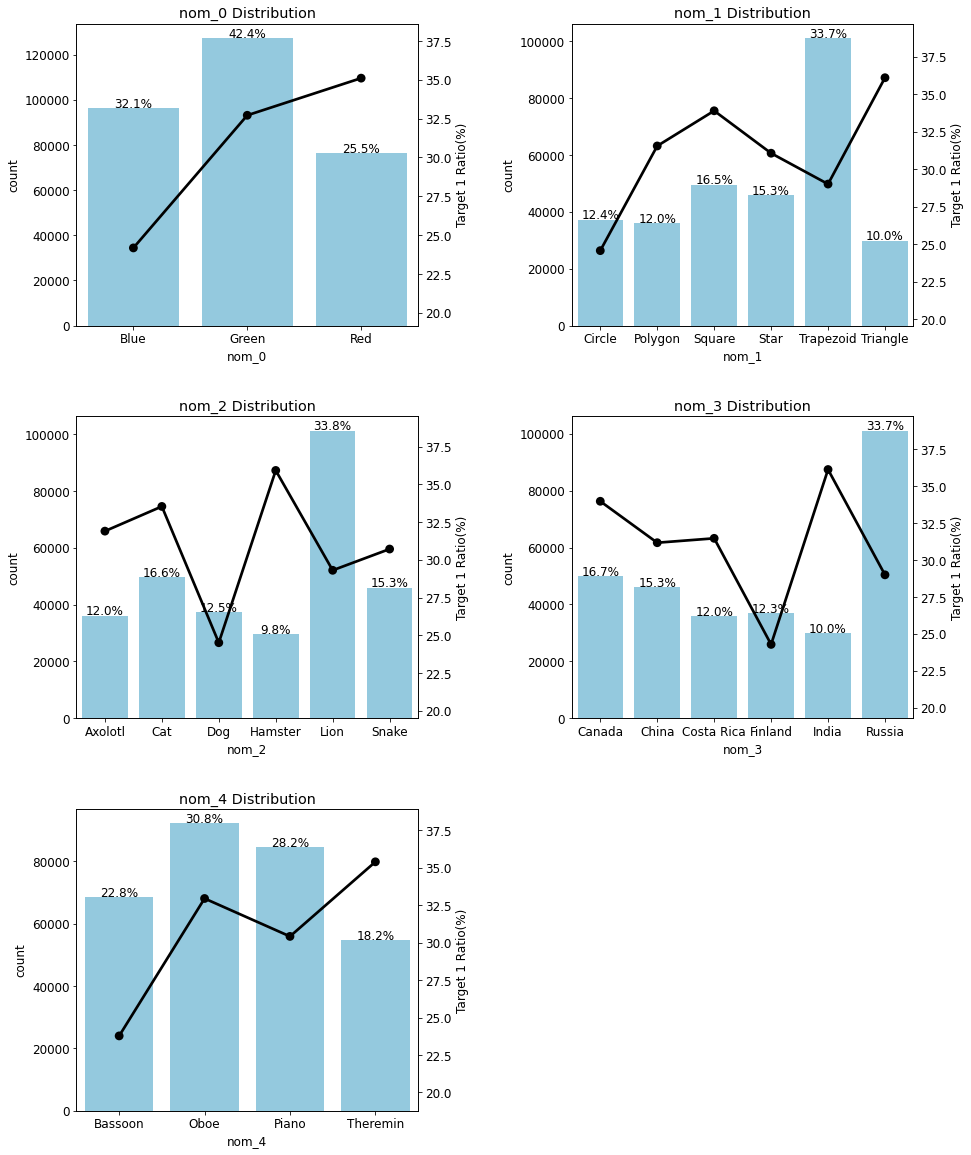

In [33]:
nom_features = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'] # 명목형 피처
plot_cat_dist_with_true_ratio(train, nom_features, num_rows=3, num_cols=2)

이 그림에서 카운트플롯은 피처별 고윳값의 비율을 나타냅니다. 대표로 첫 번째 그래프를 보겠습니다. nom_0 피처의 고윳값은 Blue, Green, Red이며, 차례로 32.1%, 42.4%, 25.5%를 차지한다는 뜻입니다.

꺾은 선 그래프는 포인트플롯으로, 해당 고윳값 중 타깃값이 1의 비율을 나타냅니다. 다시 첫 번째 그래프를 봅시다. Red 중 타깃값이 1인 데이터는 35% 정도입니다. Red 중 타깃값이 0인 데이터는 자연스럽게 65% 정도겠죠.

이 다섯 그래프가 보여주듯 nom_0부터 nom_4 피처는 고윳값별로 타깃값 1 비율이 서로 다릅니다. 이는 '타깃값에 대한 예측 능력이 있음'을 뜻합니다. 따라서 nom_0부터 nom_4 피처 중 모델링에 필요 없는 피처는 없습니다. 모두 모델링에 사용하겠습니다.

또한 명목형 피처는 순서를 무시해도 되고 고윳값 개수도 적으니, 추후 원-핫 인코딩하겠습니다.

한편, nom_5부터 nom_9 피처는 고윳값 개수가 너무 많기도 하고, 의미 없는 문자로 이루어져 있어서 시각화하기가 어렵습니다. 그렇기 때문에 여기서는 이 피처들을 시각화하지 않겠습니다. 데이터를 살펴보지 않아 모델링에 필요한 피처인지 파악하기가 힘드네요. 우선은 필요한 피처라고 가정하고 모델링에 사용하겠습니다. 아울러 이 피처들도 원-핫 인코딩을 할 예정입니다. 고윳값 개수가 많지만, 피처들의 의미를 몰라 그룹화하기도 어렵고, 전체 데이터 양이 별로 많지 않기 때문입니다.

### 순서형 피처 분포

`plot_cat_dist_with_true_ratio()` 함수를 사용해서 순서형 피처 분포도 살펴보겠습니다. 순서형 피처는 총 6개입니다. '순서형 피처 요약표'에서 확인했듯이 ord_0부터 ord_3까지는 고윳값 개수가 15개 이하입니다. 반면 ord_4와 ord_5는 고윳값이 훨씬 많습니다. 그래서 ord_0부터 ord_3까지는 2행 2열로 그래프를 그리고, ord_4와 ord_5는 2행 1열로 그래프를 따로 그리겠습니다.

먼저 ord_0부터 ord_3 피처의 분포를 살펴봅시다.

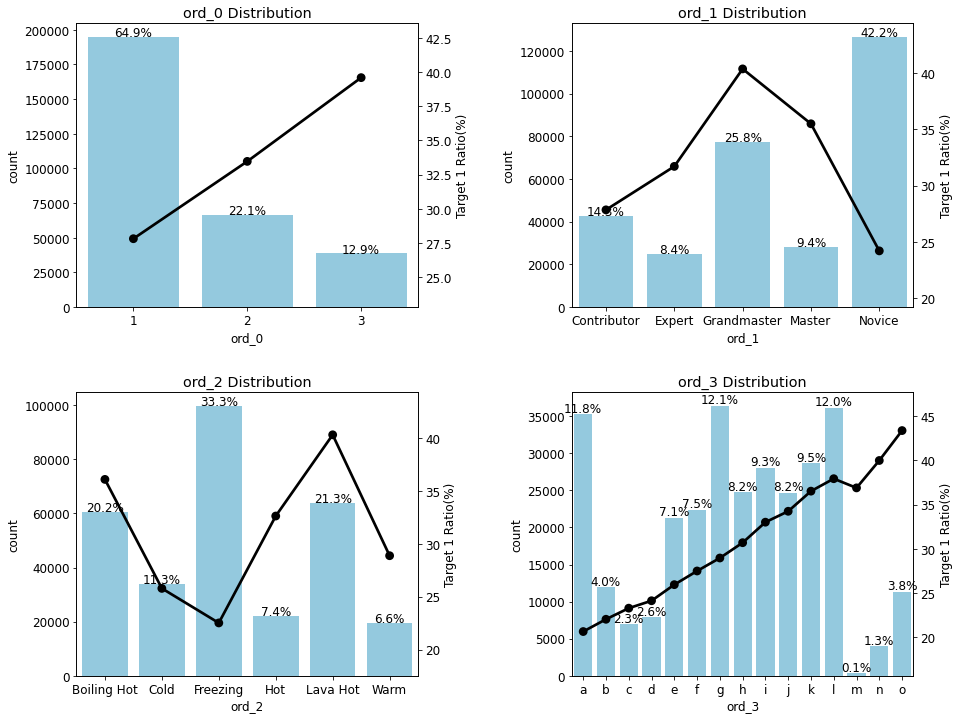

In [34]:
ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3'] # 순서형 피처
plot_cat_dist_with_true_ratio(train, ord_features, 
                              num_rows=2, num_cols=2, size=(15, 12))

그런데 ord_1과 ord_2는 피처 값들의 순서가 정렬되지 않았네요. ord_1 피처는 'Novice','Contributor', 'Expert', 'Master', 'Grandmaster' 순으로 정렬하고, ord_2 피처는‘Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot' 순으로 정렬하겠습니다.

`CategoricalDtype()`을 이용하면 피처에 순서를 지정할 수 있습니다. 이름에서 알 수 있듯이 원래는 범주형 데이터 타입을 만드는 함수인데, 파라미터를 다음과 같이 설정하면 순서도 같이 지정할 수 있습니다.
* categories : 범주형 데이터 타입으로 인코딩할 값 목록
* ordered : True로 설정하면 categories에 전달한 값의 순서가 유지됩니다.

`CategoricalDtype()`을 적용해 ord_1과 ord_2 피처에 순서를 지정해보겠습니다.

In [35]:
from pandas.api.types import CategoricalDtype 

ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

# 순서를 지정한 범주형 데이터 타입
ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

# 데이터 타입 변경
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

ord_1과 ord_2에 순서가 잘 정렬됐습니다. 정렬된 데이터를 활용해 그래프를 다시 그려보겠습니다.

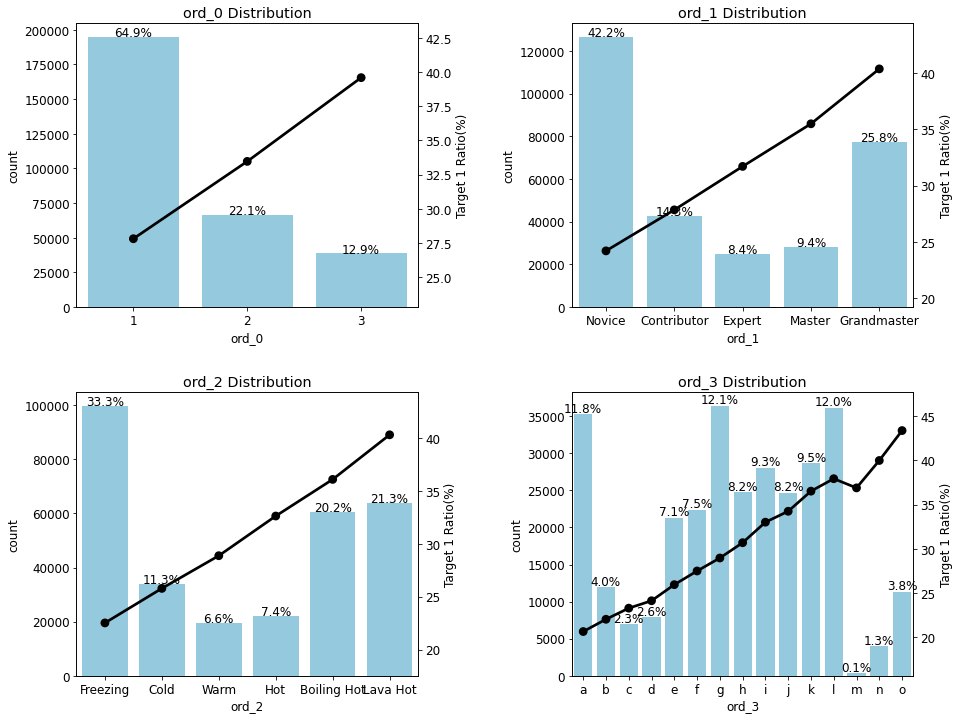

In [36]:
plot_cat_dist_with_true_ratio(train, ord_features, 
                              num_rows=2, num_cols=2, size=(15, 12))

ord_0는 숫자 크기 순으로, ord_1과 ord_2는 지정된 순서대로, ord_3는 알파벳 순으로 정렬됐습니다. 이 결과로부터 고윳값 순서에 따라 타깃값 1 비율도 비례해서 커진다는 것을 확인할 수 있습니다.

다음으로 ord_4와 ord_5의 분포를 보겠습니다. ord_4와 ord_5는 고윳값 개수가 많기 때문에 가로 길이를 늘려 2행 1열로 그리겠습니다.

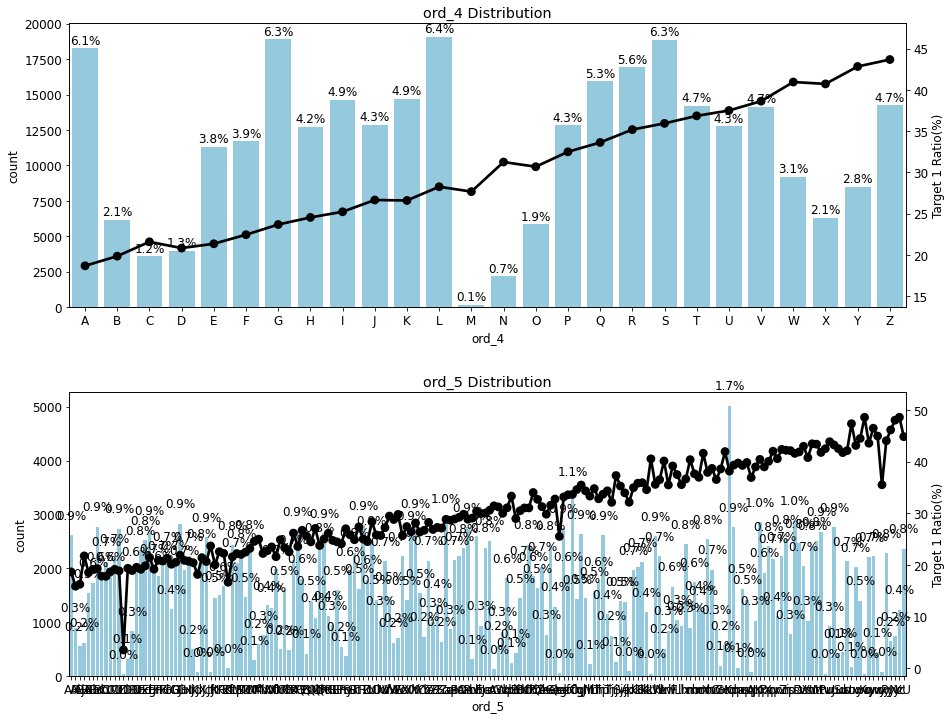

In [37]:
plot_cat_dist_with_true_ratio(train, ['ord_4', 'ord_5'], 
                              num_rows=2, num_cols=1, size=(15, 12))

ord_5는 고윳값 개수가 워낙 많다 보니 x축 라벨이 겹쳐졌습니다. 그렇지만 타깃값 1 비율의 전체적인 양상을 보는 데는 지장 없습니다. ord_4와 ord_5 모두 고윳값 순서에 따라 타깃값 1비율이 증가합니다.

이상으로 순서형 피처 모두 고윳값 순서에 따라 타깃값이 1인 비율이 증가한다는 사실을 알 수 있습니다. 모든 그래프에서 순서와 비율 사이에 상관관계가 있으므로 순서형 피처 중에서도 필요 없는 피처는 없어 보이네요. 순서형 피처 모두 모델링 시 사용하겠습니다.

#### 날짜 피처 분포

마지막으로 날짜 피처(정확하게는 요일과 월 피처) 분포도 살펴보겠습니다.

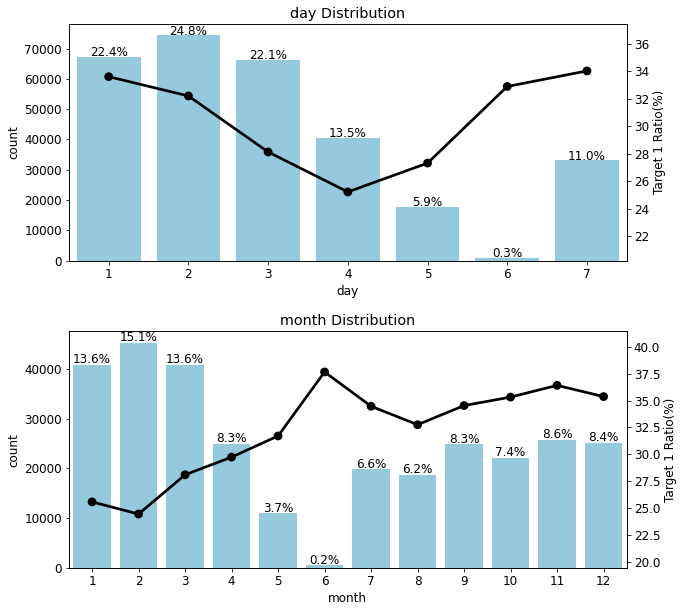

In [38]:
date_features = ['day', 'month']
plot_cat_dist_with_true_ratio(train, date_features, 
                              num_rows=2, num_cols=1, size=(10, 10))

day 피처는 7개인 걸로 보아 요일을 의미한다고 추측해볼 수 있습니다.1 에서 4로 갈수록 타깃값 1 비율이 줄어들고, 다시 4에서 7로 갈수록 비율이 늘어납니다. month 피처는 day 피처와 다소 반대되는 양상을 보입니다.

가만보니 요일과 월 피처 모두 값이 숫자입니다. 머신러닝 모델은 숫자 값을 가치의 크고 작음으로 해석합니다. 가령 1월은 3월보다 2월과 더 가까운(비슷한) 데이터라고 여깁니다. 올바른 해석이죠. 그런데 12월과 다음해 1월, 그리고 1월과 2월의 차이는 어떤가요? 둘 다 한 달 차이지만 머신러닝 모델은 차이가 같다고 보지 않습니다. 12와 1의 차이는 11이나 되기 때문이죠. 이럴 때 삼각함수(sin, cos)를 사용해 인코딩하면 시작과 끝이 매끄럽게 연결되어 문제가 해결됩니다. 이렇듯 매년, 매월, 매주, 매일 반복되는 데이터를 순환형 데이터(cyclical data)라고 부릅니다. 계절, 월, 요일, 시간 등이 이에 속합니다.

하지만 제가 미리 테스트해본 결과, 본 경진대회에서는 요일, 월 피처에 원-핫 인코딩을 적용하는게 오히려 성능이 좋았습니다. 데이터가 그리 크지 않아서 삼각함수 인코딩이 제대로 효과를 발휘하지 못했을 수 있습니다. 따라서 명목형 피처를 인코딩할 때와 마찬가지로 요일과 월 피처에도 원-핫 인코딩을 적용하겠습니다.

<br>

## 3. 분석 정리 및 모델링 전략

### 분석 정리
1. 결측값은 없습니다.

2. 모든 피처가 중요하여 제거할 피처를 찾지 못했습니다.

3. 이진 피처 인코딩 : 값이 숫자가 아닌 이진 피처는 0과 1로 인코딩합니다.

4. 명목형 피처 인코딩 : 전체 데이터가 크지 않으므로 모두 원-핫 인코딩합니다.

5. 순서형 피처 인코딩 : 고윳값들의 순서에 맞게 인코딩합니다(이미 숫자로 되어 있다면 인코딩 필요 없음).

6. 날짜 피처 인코딩 : 값의 크고 작음으로 해석되지 못하도록 원-핫 인코딩합니다.

### 모델링 전략

이번 장의 목표는 데이터 특성에 따른 맞춤형 인코딩 방법을 익히기입니다. 따라서 머신러닝 모델은 기본적인 로지스틱 회귀 모델을 계속 사용하면서 피처 엔지니어링에 집중하겠습니다. 그 외 간단하게 이용할 수 있는 하이퍼파라미터 최적화 등의 성능 개선 팁을 추가로 소개하겠습니다.
* 베이스라인 모델: 로지스틱 회귀 모델
    * 피처 엔지니어링 : 모든 피처를 원-핫 인코딩
* 성능 개선 : 추가 피처 엔지니어링과 하이퍼파라미터 최적화
    * 피처 엔지니어링 : 피처 맞춤 인코딩과 피처 스케일링
    * 하이퍼파라미터 최적화 : 그리드서치
    * 추가 팁 : 검증 데이터를 훈련에 이용

<br>

# Categorical Feature Encoding Challenge Baseline

## 1. Baseline Start

이번 절에서는 모든 피처를 원-핫 인코딩한 뒤, 로지스틱 회귀 모델로 베이스라인을 만들어보겠습니다. 전체 프로세스는 6장과 같습니다.

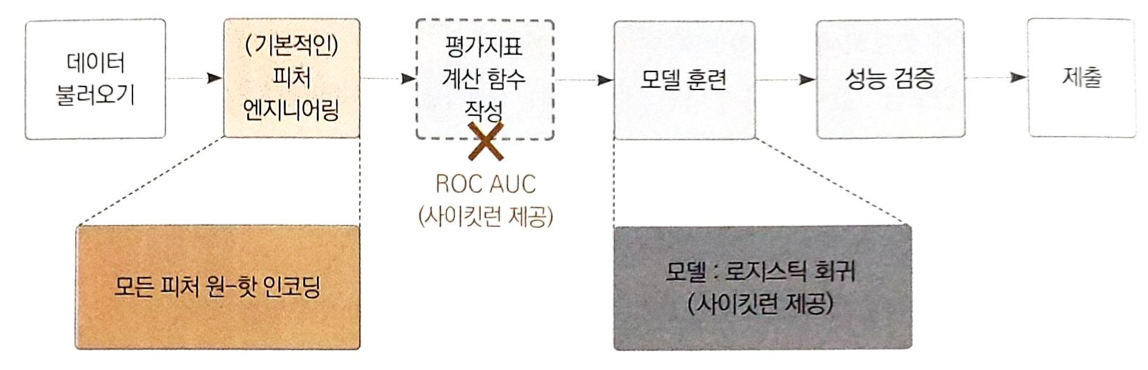

이번 절에서 다룰 코드는 간단합니다. 피처 엔지니어링도 단순하고 사이킷런이 제공하는 모델을 사용할 것이기 때문입니다.

먼저 훈련, 테스트, 제출 샘플 파일을 불러옵니다.

In [39]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

<br>

## 2. 피처 엔지니어링

### 데이터 합치기

머신러닝 모델은 문자 데이터를 인식하지 못한다고 했습니다. 그렇기 때문에 문자를 숫자로 바꿔야 합니다. 이처럼 데이터의 표현 형태를 바꾸는 작업을 인코딩이라고 합니다. 불러온 데이터는 문자를 포함한 데이터이므로 인코딩을 해야 합니다. 훈련 데이터와 테스트 데이터에 동일한 인코딩을 적용하기 위해 편의상 둘을 합치겠습니다. 그런 다음 합친 DataFrame에서 타깃값을 제거하겠습니다. 피처와 타깃값은 따로 분리해서 모델링해야 하기 때문입니다.

`concat()` 함수를 써서 축을 따라 두 DataFrame을 합쳤습니다. 이어서 데이터를 합친 all_data에서 `drop()` 함수로 타깃값을 제거했습니다. 결과는 다음과 같습니다.

In [40]:
all_data = pd.concat([train, test]) # 훈련 데이터와 테스트 데이터 합치기
all_data = all_data.drop('target', axis=1) # 타깃값 제거
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,...,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,...,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,...,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1


훈련 데이터와 테스트 데이터를 합치니 행 개수가 50만 개이며, 타깃값이 빠져서 피처는 23개입니다.

### 원-핫 인코딩

원-핫 인코딩은 대표적인 인코딩 방법입니다. 모델링에 사용하기 위해 모든 피처를 원-핫 인코딩해보겠습니다. 준비한 all_data에 원-핫 인코딩을 적용해보죠.

In [41]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() # 원-핫 인코더 생성
all_data_encoded = encoder.fit_transform(all_data) # 원-핫 인코딩 적용

원-핫 인코더 객체를 생성하고 all_data의 모든 피처를 인코딩하여 새로운 변수 all_data_encoded에 저장했습니다.

간단하게 인코딩이 끝났습니다.

### 데이터 나누기

공통으로 적용할 인코딩이 끝났으니 훈련 데이터와 테스트 데이터를 다시 나누겠습니다. 앞서 concat() 함수를 써서 훈련 데이터와 테스트 데이터를 이어붙였죠? 그러니 여기서는 행 번호를 기준으로 다시 나눌 수 있습니다.

In [42]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_encoded[:num_train] # 0~num_train - 1행
X_test = all_data_encoded[num_train:] # num_train~마지막 행

y = train['target']

추가로 마지막 줄에서 타깃값을 y변수에 저장해뒀습니다. 사람이 학습할 때 정답이 필요하듯, 머신러닝 모델 훈련 시에도 타깃값(정답)이 필요하기 때문입니다.

다음으로 훈련 데이터에서 일부를 검증 데이터로 나누겠습니다. 훈련 데이터는 모델 훈련에 사용하고, 검증 데이터는 모델 성능 검증에 사용합니다.

이렇게 나누는 이유는 검증 데이터를 이용해 제출 전에 모델 성능을 평가해보기 위해서입니다. 우리가 무언가 수정했을 때 모델 성능이 좋아졌는지 가늠할 수 있어야겠죠? 그래야 모델링을 잘했는지, 아니면 다른 방법을 찾아봐야 할지 판단할 수 있습니다.

앞서 훈련 데이터와 테스트 데이터를 나눌 땐 행 번호로 명확하게 나눌 수 있어서 행을 기준으로 분리했습니다.하지만 여기서 훈련 데이터와 검증 데이터를 나눌 땐 `train_test_split()` 함수를 사용합니다. 타깃값 공정 배분 여부, 훈련데이터/검증 데이터 비율, 데이터 무작위 추출 등을 설정할 수 있기 때문입니다.

In [43]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y,
                                                      test_size=0.1,
                                                      stratify=y,
                                                      random_state=10)

`train_test_split()` 은 전체 데이터를 훈련 데이터와 검증(혹은 테스트) 데이터로 나누는 함수입니다. 첫 번째 인수로는 피처(X_train)를, 두 번째 인수로는 타깃값(y)을 전달합니다. test_size와 stratify는 설명할 게 많으니 잠시 미루고, 마지막 random_state는 시드값을 고정하여 다음에 실행해도 같은 결과가 나오게 해줍니다.

test_size는 검증 데이터 크기를 지정하는 파라미터입니다. 값이 정수면 검증 데이터의 개수를, 실수면 비율을 의미합니다. 여기서는 0.1을 전달했으므로 10%를 검증 데이터로 분리하겠다는 뜻입니다.

stratify는 사회학에서 '수평적 지위 집단으로 나눈다'라는 의미입니다. 즉, stratify 파라미터로 지정한 값을 각 그룹에 '공정하게' 배분한다는 뜻입니다. 여기서는 타깃값인 y를 전달했으므로 타깃값이 훈련 데이터와 검증 데이터에 같은 비율로 포함되게끔 나눠줍니다.

stratify 파라미터를 지정하지 않으면 훈련 데이터와 검증 데이터에 타깃값이 불균형하게 분포될수 있습니다. 그렇게 되면 훈련과 검증이 올바르게 이루어지지 않으므로 되도록이면 stratify 파라미터에 타깃값을 넘겨주는 게 바람직합니다.

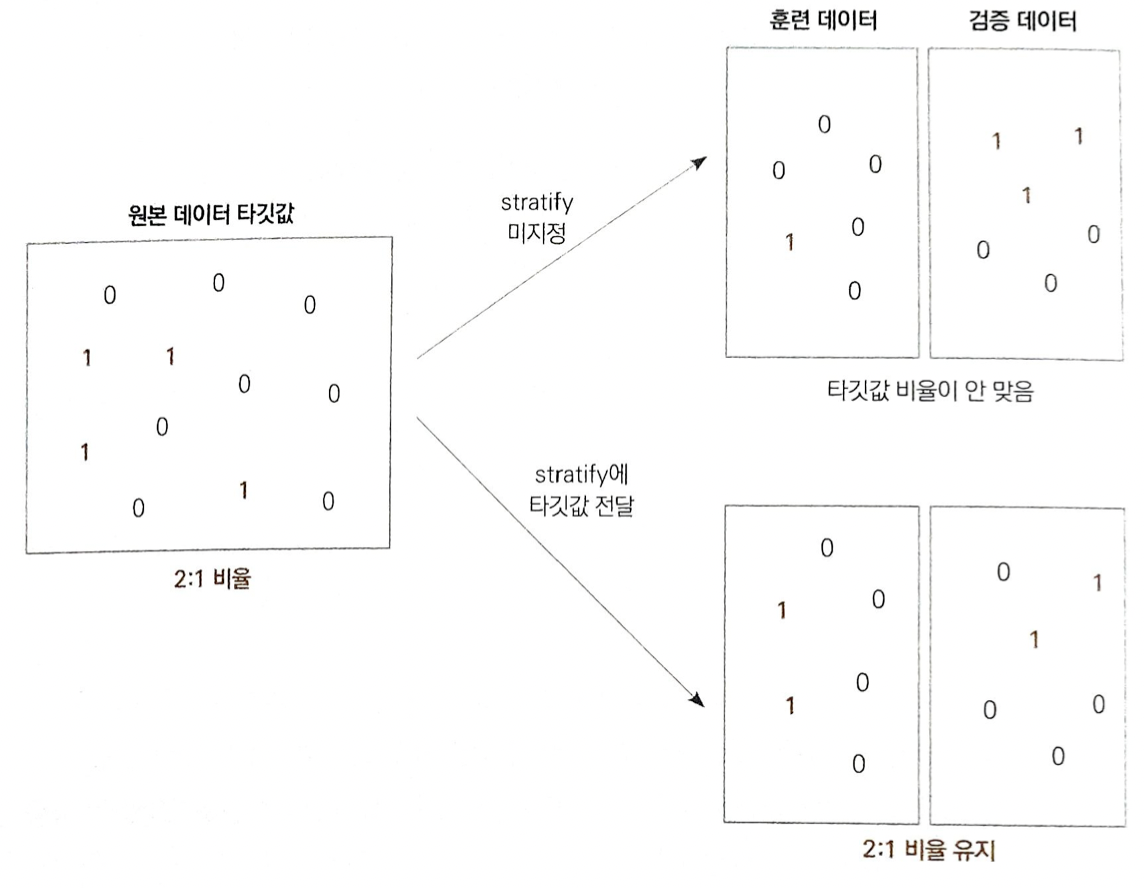

이로써 데이터 준비를 마쳤습니다.

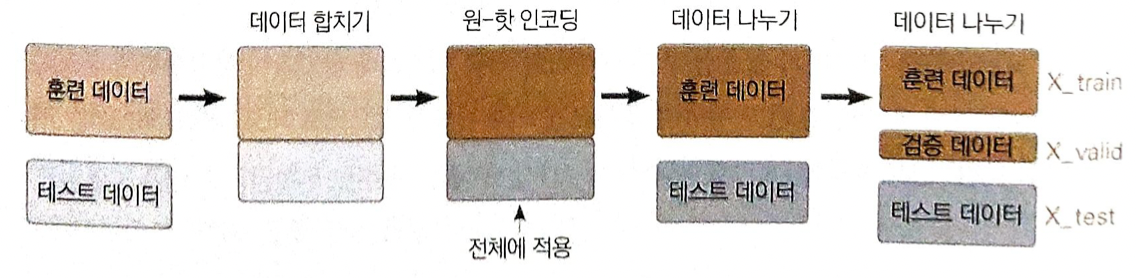

<br>

## 3. 모델 훈련

이제 모델을 생성한 뒤, 앞에서 준비한 데이터를 사용해서 훈련해보겠습니다. 선형 회귀 방식을 응용해 분류를 수행하는 로지스틱 회귀 모델을 사용하겠습니다.

In [44]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, random_state=42) # 모델 생성
logistic_model.fit(X_train, y_train) # 모델 훈련

LogisticRegression(max_iter=1000, random_state=42)

단 두 줄로 모델 생성과 훈련이 끝났네요. 베이스라인 모델이므로 모델의 파라미터는 간단하게 설정했습니다.
* max_iter : 모델의 회귀 계수를 업데이트하는 반복 횟수. 모델 훈련 시 회귀 계수를 업데이트하면서 훈련하는데, 이때 업데이트를 몇 번 할지를 정합니다.
* random_state : 값을 지정하면 여러 번 실행해도 매번 똑같은 결과가 나옵니다. 아무 값으로지정해도 상관없습니다.

이제 테스트 데이터를 사용해 예측하고 제출하는 일만 남았습니다.

<br>

## 4. 모델 성능 검증

사이킷런은 타깃값 예측 메서드를 두 가지 제공합니다. 바로 `predict()`와 `predict_proba()`입니다. 먼저 `predict()` 메서드는 타깃값 자체 (0이냐 1이냐)를 예측합니다. 반면, `predict_proba()`는 타깃값의 확률(0일 확률과 1일 확률)을 예측합니다.

다음은 `predict_proba()`로 검증 데이터의 타깃값이 0 또는 1일 확률을 예측한 결과입니다.

In [45]:
logistic_model.predict_proba(X_valid)

array([[0.23265324, 0.76734676],
       [0.91403908, 0.08596092],
       [0.8303673 , 0.1696327 ],
       ...,
       [0.24860685, 0.75139315],
       [0.49451672, 0.50548328],
       [0.95655532, 0.04344468]])

첫 번째 열은 타깃값이 0일 확률을 나타내고, 두 번째 열은 1일 확률을 나타냅니다. 당연히 두 값을 합하면 1이 됩니다. 확률의 합은 1이기 때문이죠.

다음은 `predict()` 메서드로 타깃값을 예측한 결과입니다.

In [46]:
logistic_model.predict(X_valid)

array([1, 0, 0, ..., 1, 1, 0])

0 또는 1로 예측했습니다. `predict_proba()`로 예측한 결과와 비교해볼까요? 첫 행부터 보시죠. 타깃값이 0일 확률은 0.23265324이고, 1일 확률은 0.76734676입니다. 1일 확률이 더 큽니다. 그러므로 `predict()`는 타깃값을 1로 예측했습니다. 나머지 행도 마찬가지입니다.

본 대회에서는 타깃값이 1일 '확률'을 예측해야 합니다. 따라서 `predict_proba()` 메서드로 예측한 결과의 두 번째 열을 타깃 예측값으로 사용합니다.

검증 데이터를 활용해 타깃값을 예측해보시죠.

In [47]:
# 검증 데이터를 활용한 타깃 예측
y_valid_preds = logistic_model.predict_proba(X_valid)[:, 1]

y_valid_preds 변수에는 검증 데이터 타깃값이 1일 확률이 저장됩니다.

이제 타깃 예측값인 y_valid_preds와 실제 타깃값인 y_valid를 이용해 ROC AUC를 구해볼까요? 모델 성능을 검증하려는 절차입니다. ROC AUC 점수는 사이킷런의 `roc_auc_score()` 함수를 이용하면 쉽게 구할 수 있습니다.

In [48]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.7965


<br>

## 5. 예측 및 결과 제출

이제 '테스트 데이터'를 활용해 타깃값이 1일 확률을 예측하고, 결과를 제출해보겠습니다.

In [49]:
# 타깃값 1일 확률 예측
y_preds = logistic_model.predict_proba(X_test)[:, 1]

y_preds에 타깃값이 1일 확률을 저장했습니다.

마지막으로 제출 파일을 만듭니다.

In [50]:
# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission.csv')

끝났습니다. 커밋 후 제출해보시죠.

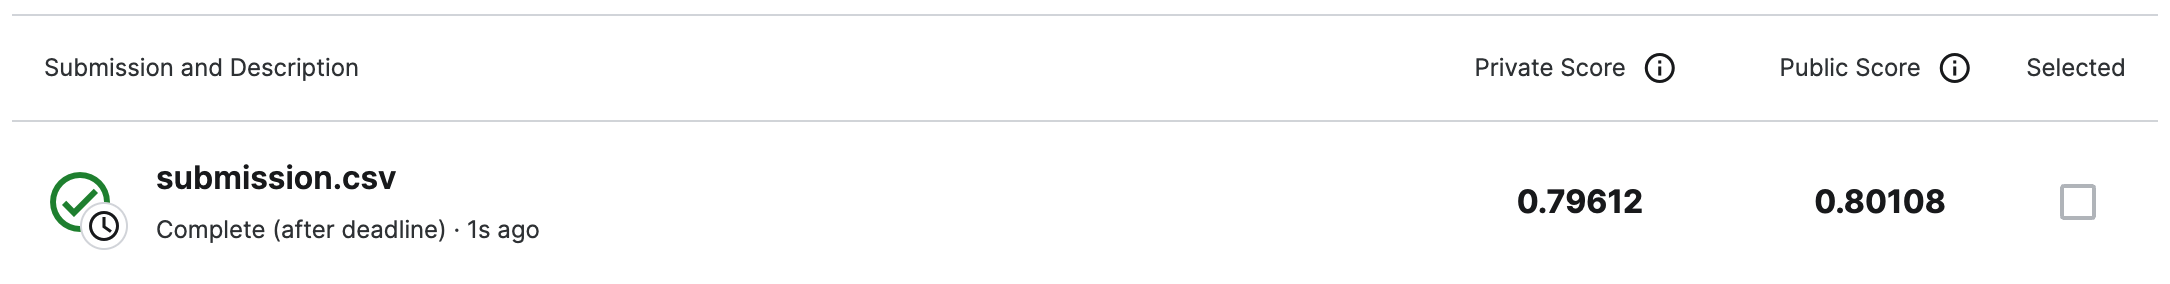

프라이빗 점수는 0.79612, 퍼블릭 점수는 0.80108이 나오네요. 프라이빗 점수는 대회가 종료된 후 전체 테스트 데이터로 평가한 점수입니다. 반면에 퍼블릭 점수는 대회가 종료되기 전, 테스트 데이터 일부만 사용해 평가한점수입니다. 따라서 프라이빗 점수가 최종 점수이며, 퍼블릭 점수는 큰 의미가 없습니다.

이 정도 점수면 몇 등인지 Learderboard 메뉴에서 확인해보세요. 프라이빗 점수 기준으로 1,338명 중 705등입니다. 상위 52.7%로, 그다지 좋지 않습니다. 다음 절에서 모델 성능을 향상시켜 등수를 높여보겠습니다.

다음 절부터 중요한 내용을 다릅니다. 지금까지 이해가 잘 됐다면 다음 절도 쉽게 따라오실 겁니다. 심호흡 한번 하시고요. 705 등에서 2등으로 도약해보죠!